## Import Packages

In [1]:
import sys
import cv2
import dlib
import time
import numpy as np
import face_blend_common as fbc
import matplotlib.pyplot as plt

## Download Models

In [225]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2020-08-14 19:00:30--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  8.81MB/s    in 7.6s    

2020-08-14 19:00:38 (7.99 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



## Read & Display Images

In [211]:
img_source = cv2.imread('/content/swap_source.jpg')
img_source_display = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)

img_target = cv2.imread('/content/swap_target.jpg')
img_target_display = cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB)

img_source_warped = np.copy(img_target)

(-0.5, 1599.5, 2373.5, -0.5)

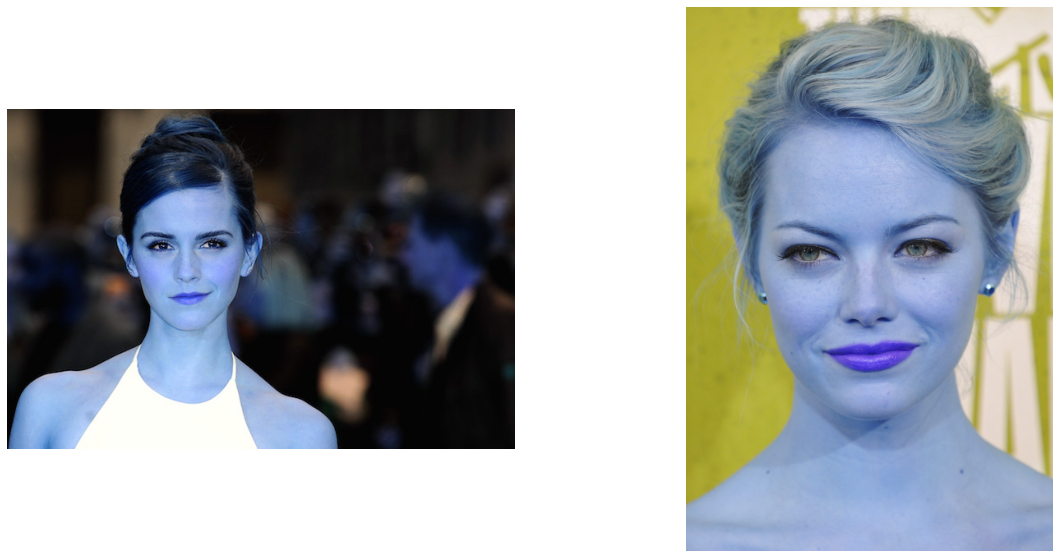

In [212]:
# Display Images
plt.figure(figsize = (20, 10))

plt.subplot(121)
plt.imshow(img_source)
plt.axis('off')

plt.subplot(122)
plt.imshow(img_target)
plt.axis('off')

## Detect Landmarks

### Initialize model and detect landmark points

In [213]:
# Initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Read array of corresponding points
points_source = fbc.getLandmarks(detector, predictor, img_source)
points_target = fbc.getLandmarks(detector, predictor, img_target)

### Display landmarks

(-0.5, 1599.5, 2373.5, -0.5)

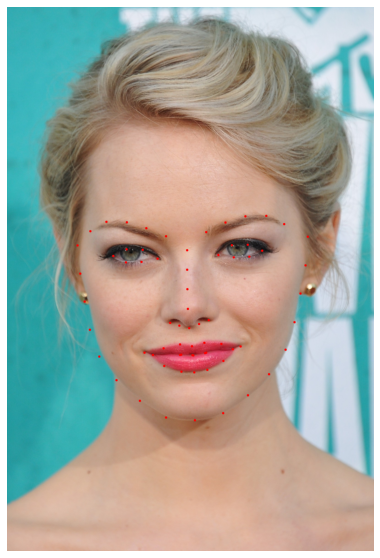

In [214]:
# Display Landmarks
img_temp = img_target_display.copy()
for p in points_target:
    cv2.circle(img_temp, p, 5, (255, 0, 0), -1)

plt.figure(figsize = (20, 10))
plt.imshow(img_temp)
plt.axis('off')

## Set Convex Hull

### Create convex hull

In [215]:
# Find convex hull
hull_index = cv2.convexHull(np.array(points_target), returnPoints=False)

# Create convex hull lists
hull_source = []
hull_target = []
for i in range(0, len(hull_index)):
    hull_source.append(points_source[hull_index[i][0]])
    hull_target.append(points_target[hull_index[i][0]])

### Display convex hull

(-0.5, 1599.5, 2373.5, -0.5)

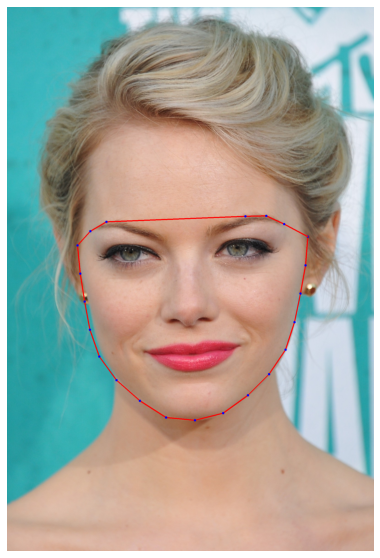

In [216]:
# Display Convex Hull
img_temp = img_target_display.copy()
num_points = len(hull_target)

for i in range(0, num_points):
    cv2.line(img_temp, hull_target[i], hull_target[(i + 1) % num_points], (255, 0, 0), 3)
    cv2.circle(img_temp, hull_target[i], 5, (0, 0, 255), -1)

plt.figure(figsize=(20, 10))
plt.imshow(img_temp)
plt.axis('off')

### Get hull mask

In [217]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull_target)):
    hull8U.append((hull_target[i][0], hull_target[i][1]))

mask = np.zeros(img_target.shape, dtype=img_target.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))

(-0.5, 1599.5, 2373.5, -0.5)

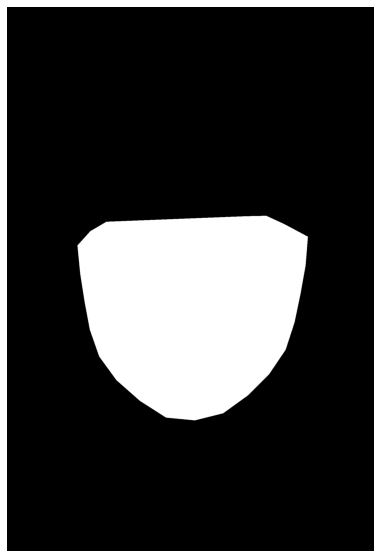

In [218]:
# Display Mask
plt.figure(figsize=(20, 10))
plt.imshow(mask)
plt.axis('off')

### Create triangulation

In [219]:
# Find Delaunay traingulation for convex hull points
img_target_size = img_target.shape    
rect = (0, 0, img_target_size[1], img_target_size[0])

dt = fbc.calculateDelaunayTriangles(rect, hull_target)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

In [220]:
img_source_temp = img_source_display.copy()
img_target_temp = img_target_display.copy()

tris_source = []
tris_target = []
for i in range(0, len(dt)):
    tri_source = []
    tri_target = []
    for j in range(0, 3):
        tri_source.append(hull_source[dt[i][j]])
        tri_target.append(hull_target[dt[i][j]])

    tris_source.append(tri_source)
    tris_target.append(tri_target)

cv2.polylines(img_source_temp,np.array(tris_source),True,(0,0,255),2);
cv2.polylines(img_target_temp,np.array(tris_target),True,(0,0,255),2);

(-0.5, 1599.5, 2373.5, -0.5)

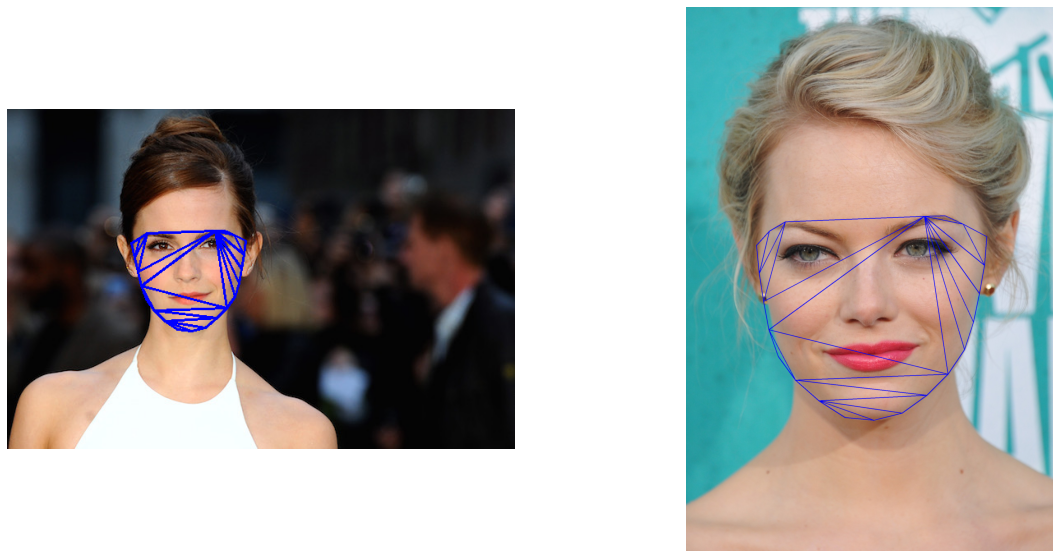

In [221]:
# Display Triangulation
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(img_source_temp)
plt.axis('off')

plt.subplot(122)
plt.imshow(img_target_temp)
plt.axis('off')

## Swap Face

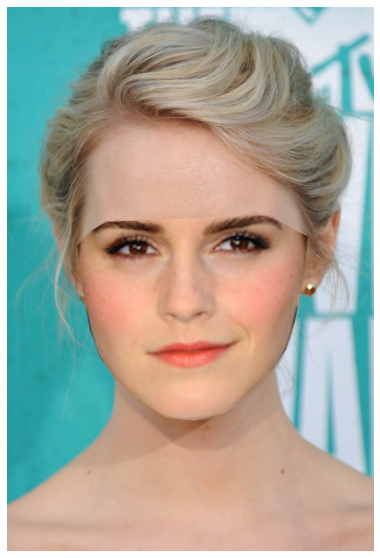

In [222]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris_source)):
    fbc.warpTriangle(img_source, img_source_warped, tris_source[i], tris_target[i])

plt.figure(figsize=(20, 10))
plt.imshow(np.uint8(img_source_warped)[:,:,::-1])
plt.axis('off');

In [223]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img_source_warped), img_target, mask, center, cv2.NORMAL_CLONE)

(-0.5, 1599.5, 2373.5, -0.5)

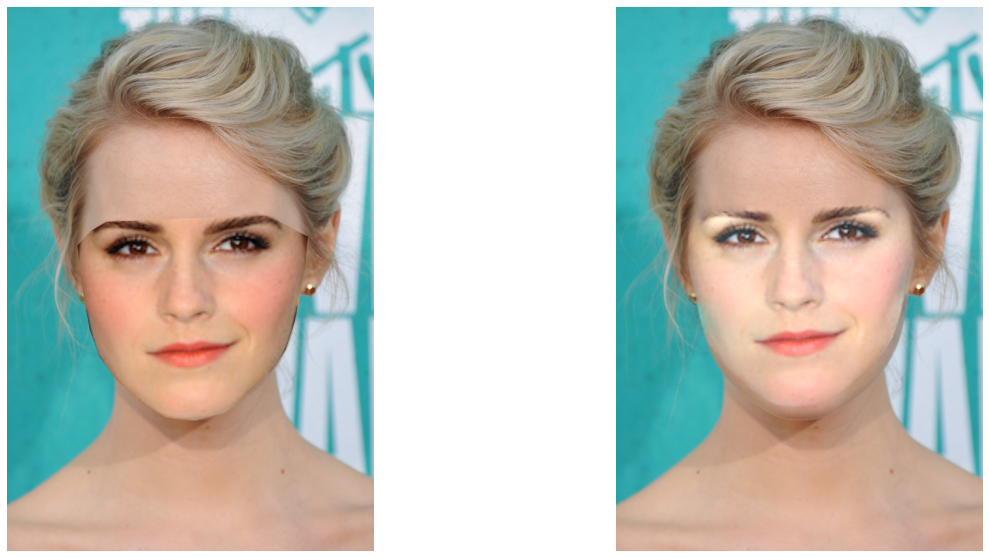

In [224]:
plt.figure(figsize=(20, 10))

plt.subplot((121))
plt.imshow(np.uint8(img_source_warped)[:,:,::-1])
plt.axis('off')

plt.subplot((122))
plt.imshow(output[:,:,::-1])
plt.axis('off')